# DETR Metrics

This notebook calculates the metrics for the DETR model as per the methodology described in the paper.

In [1]:
# %%
# Change directory to the root of the project
if __name__ == "__main__":
    import os
    import sys

    import dotenv

    os.chdir(os.getcwd().split("notebooks")[0])
    print(f"cwd: {os.getcwd()}")
    dotenv.load_dotenv()
    sys.path.append(os.getenv("PACKAGEPATH", ""))


cwd: /home/andre/wikki/patsa-bil


## Imports and Constants

In [2]:
import copy
import os

import dotenv
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage.color import label2rgb
from sklearn.model_selection import train_test_split
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import tqdm

# import torchvision
import torchvision.transforms.v2 as T

from imagelog_ai.features.methodologies.detr.datasets.dataset import (
    DETRDataset,
)
from imagelog_ai.features.methodologies.detr.modules.lit_module import (
    LitDETR,
)
from imagelog_ai.features.methodologies.sam.utils.iou import calc_iou
from imagelog_ai.utils.io_functions import json_load

In [3]:
# %%
# Load environment variables
dotenv.load_dotenv(".env", override=True)

True

In [4]:
torch.set_float32_matmul_precision("high")
np.random.seed(0)
torch.manual_seed(0)

OUTPUT_DIR: str = "test_figures"
OVERRIDE: bool = False

pil_transform = T.ToPILImage()
tensor_transform = T.ToImage()


def tensor_to_numpy_transform(x: torch.Tensor) -> np.ndarray:
    return x.numpy().transpose((1, 2, 0))


def collate_fn(batch):
    x = torch.stack([item[0] for item in batch])
    y = [item[1] for item in batch]
    return x, y

In [5]:
# Define checkpoint path
CHECKPOINT_PATH: str = "./11/cff42f8e2e8c464bbafc9474a46765e2/checkpoints/epoch=33-step=442.ckpt"

## Datasets

In [ ]:
def transform_func(x):
    """
    Transforms the input tensor by selecting the first three channels.

    Args:
        x (torch.Tensor): Input tensor of shape (C, H, W).

    Returns:
        torch.Tensor: Transformed tensor of shape (3, H, W).
    """
    # Select channels
    x = x[:3, :, :]
    # Convert from RGB to grayscale
    grayscale_transform = T.Grayscale(num_output_channels=3)
    x = grayscale_transform(x)
    # Invert intensities
    x = x.max() - x
    # Convert to float
    x = x.float()
    # Scale to [0, 1]
    x = x / x.max()
    return x


def target_transform_func(x):
    """
    Applies transformations to the target data.

    Args:
        x (dict): A dictionary containing the target data.

    Returns:
        dict: The transformed target data.
    """
    # Convert bboxes to float
    x["boxes"] = x["boxes"].float()
    # Binarize labels
    x["labels"] = torch.where(x["labels"] > 0, 1, 0)
    return x


project_name = "DETR"
project_settings = json_load(f"experiment_configs/{project_name}.json")

# test dataset
dataset = DETRDataset(
    project_name,
    project_settings["preprocess_name"],
    project_settings["list_datasource_names"],
    project_settings["class_list"],
    project_settings["others_class_list"],
    project_settings["background_class"],
    transform=transform_func,
    target_transform=target_transform_func,
    target_boxes=True,
    target_labels=True,
    target_masks=True,
    boxes_location="masks",
    masks_location="labels",
)
# Filter images wtih invalid data
images_to_remove = [
    "0053.png",
    "0054.png",
    "0055.png",
    "0056.png",
    "0057.png",
    "0058.png",
    "0059.png",
    "0060.png",
    "0061.png",
    "0062.png",
    "0064.png",
    "0080.png",
    "0086.png",
    "0096.png",
]
for image_to_remove in images_to_remove:
    # If dataframe["image_file"] contains image_to_remove, remove it
    dataset.dataframe = dataset.dataframe[
        ~dataset.dataframe["image_file"].str.contains(image_to_remove)
    ]
    dataset.dataframe_detr = dataset.dataframe_detr[
        ~dataset.dataframe_detr["image_file"].str.contains(image_to_remove)
    ]
# Filter dataset rows with "component" == 0
dataset.dataframe = dataset.dataframe[dataset.dataframe["component"] != 0].reset_index(
    drop=True
)
print(dataset.dataframe)

In [7]:
# Separate dataset into train and val (80% train, 20% val)
idxs_train, idxs_test = train_test_split(
    np.arange(len(dataset)), test_size=0.2, random_state=0
)
train_dataset = copy.deepcopy(dataset)
train_dataset.dataframe_detr = dataset.dataframe_detr.copy(deep=True)
train_dataset.dataframe_detr = train_dataset.dataframe_detr.iloc[
    idxs_train
].reset_index(drop=True)
val_dataset = copy.deepcopy(dataset)
val_dataset.dataframe_detr = dataset.dataframe_detr.copy(deep=True)
val_dataset.dataframe_detr = val_dataset.dataframe_detr.iloc[idxs_test].reset_index(
    drop=True
)

In [ ]:
# Iterate on all dataset samples and check if the labels are valid
for idx in tqdm.trange(len(dataset)):
    image, labels = dataset[idx]
    # Check if the boxes are valid
    if labels["boxes"].shape[0] == 0:
        print(f"Image {idx} has no boxes.")
    else:
        # Check if the boxes are valid
        for box in labels["boxes"]:
            if box[2] <= box[0] or box[3] <= box[1]:
                print(f"Image {idx} has invalid boxes.")
    # Check if the masks are valid
    if labels["masks"].shape[0] == 0:
        print(f"Image {idx} has no masks.")
    else:
        # Check if the masks are valid
        if labels["masks"].shape[1] == 0:
            print(f"Image {idx} has invalid masks.")

In [ ]:
dataset_images = dataset.dataframe["image_file"].unique()
image_path = dataset_images[0]
print(image_path)
# Get all indexes from the dataset with the same image_path
indexes = dataset.dataframe[dataset.dataframe["image_file"] == image_path].index
print(indexes)

## DETR

In [22]:
model = LitDETR.load_from_checkpoint(CHECKPOINT_PATH)
model.postprocessors["segm"].threshold = 0.1
model

Building a DETR model with 1 classes


LitDETR(
  (model): DETRsegm(
    (detr): DETR(
      (transformer): Transformer(
        (encoder): TransformerEncoder(
          (layers): ModuleList(
            (0-5): 6 x TransformerEncoderLayer(
              (self_attn): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
              )
              (linear1): Linear(in_features=256, out_features=2048, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (linear2): Linear(in_features=2048, out_features=256, bias=True)
              (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
              (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
              (dropout1): Dropout(p=0.1, inplace=False)
              (dropout2): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (decoder): TransformerDecoder(
          (layers): ModuleList(
            (0-5): 6 x TransformerDecoderLay

### Plot sample

Image shape: torch.Size([1, 3, 360, 360])
GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([1, 360, 360])


Text(0.5, 1.0, 'Pred Mask')

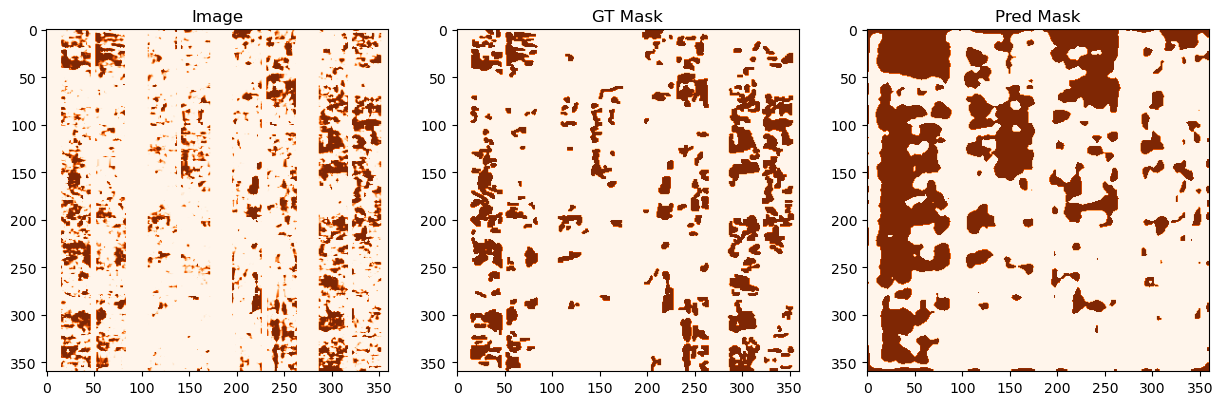

In [23]:
# Plot a sample image, its masks, and the predicted masks
image, labels = dataset[0]
image = image.unsqueeze(0)
print(f"Image shape: {image.shape}")
labels = [labels]

masks = labels[0]["masks"]
gt_mask = torch.zeros_like(masks[0])
for mask in masks:
    gt_mask = torch.logical_or(gt_mask, mask)
gt_mask = gt_mask.byte().unsqueeze(0)
print(f"GT Mask shape: {gt_mask.shape}")

model.eval()
# evaluate sample on model
with torch.no_grad():
    image = image.to(model.device)
    outputs = model(image)
    orig_target_sizes = torch.stack([t["orig_size"] for t in labels], dim=0).to(
        model.device
    )
    preds = model.postprocessors["bbox"](outputs, orig_target_sizes)
    if "segm" in model.postprocessors.keys():
        target_sizes = torch.stack([t["size"] for t in labels], dim=0).to(
            model.device
        )
        preds = model.postprocessors["segm"](
            preds, outputs, orig_target_sizes, target_sizes
        )
# join mask predictions
pred_mask = torch.zeros_like(preds[0]["masks"][0])
for pred in preds:
    pred["masks"] = torch.squeeze(pred["masks"] > LitDETR.MASK_THRESHOLD, dim=1).byte()
    for score, mask in zip(pred["scores"], pred["masks"]):
        # if score > LitDETR.MASK_THRESHOLD:
        pred_mask = torch.logical_or(pred_mask, mask)
pred_mask = pred_mask.cpu()
# pred_mask = torch.where(pred_mask > 1, 1, pred_mask)
# pred_mask = (pred_mask > LitDETR.MASK_THRESHOLD).byte().cpu()
print(f"Pred Mask shape: {pred_mask.shape}")

# Plot images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# axs[0].imshow(tensor_to_numpy_transform(image[0].cpu()))
axs[0].imshow(image[0][2].cpu(), cmap="Oranges")
axs[0].set_title("Image")
axs[1].imshow(gt_mask[0], cmap="Oranges")
axs[1].set_title("GT Mask")
axs[2].imshow(pred_mask[0].cpu(), cmap="Oranges")
axs[2].set_title("Pred Mask")

### Plot All Samples

In [ ]:
# Plot all samples
for idx in range(len(dataset)):
    image, labels = dataset[idx]
    image = image.unsqueeze(0)
    labels = [labels]
    masks = labels[0]["masks"]
    gt_mask = torch.zeros_like(masks[0])
    for mask in masks:
        gt_mask = torch.logical_or(gt_mask, mask)
    gt_mask = gt_mask.byte().unsqueeze(0)

    model.eval()
    # evaluate sample on model
    with torch.no_grad():
        image = image.to(model.device)
        outputs = model(image)
        orig_target_sizes = torch.stack([t["orig_size"] for t in labels], dim=0).to(
            model.device
        )
        preds = model.postprocessors["bbox"](outputs, orig_target_sizes)
        if "segm" in model.postprocessors.keys():
            target_sizes = torch.stack([t["size"] for t in labels], dim=0).to(
                model.device
            )
            preds = model.postprocessors["segm"](
                preds, outputs, orig_target_sizes, target_sizes
            )
    # join mask predictions
    pred_mask = torch.zeros_like(preds[0]["masks"][0])
    for pred in preds:
        pred["masks"] = torch.squeeze(
            pred["masks"] > LitDETR.MASK_THRESHOLD, dim=1
        ).byte()
        for score, mask in zip(pred["scores"], pred["masks"]):
            # if score > LitDETR.MASK_THRESHOLD:
            pred_mask = torch.logical_or(pred_mask, mask)
    pred_mask = pred_mask.cpu()

    # Plot images
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image[0][2].cpu(), cmap="Oranges")
    axs[0].set_title("Image")
    axs[1].imshow(gt_mask[0], cmap="Oranges")
    axs[1].set_title("GT Mask")
    axs[2].imshow(pred_mask[0], cmap="Oranges")
    axs[2].set_title("Pred Mask")
    plt.show()
    plt.close(fig)

### Plot single sample

Pred Mask shape: torch.Size([1, 360, 360])


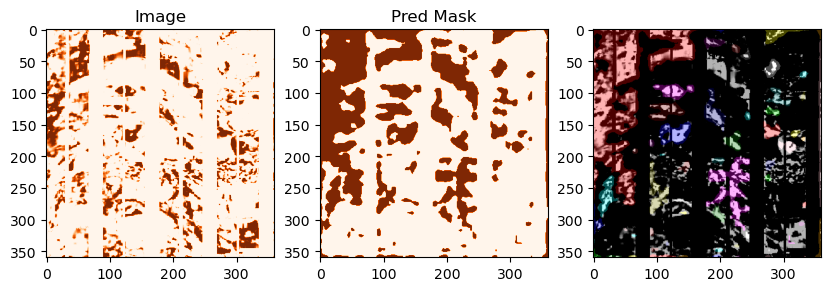

In [ ]:
# Set colors
colors = [
    "red",
    "blue",
    "green",
    "yellow",
    "orange",
    "purple",
    "pink",
    "brown",
    "gray",
    "black",
    "white",
    "cyan",
    "magenta",
    "teal",
    "navy",
    "olive",
    "maroon",
    "lime",
    "aqua",
    "silver",
]

image_id = "000134"
IMAGE_COMPARE_PATH = f"data/processed/test_SKLearnODExample/transform_test/WIN_AUG_BBOX_{project_settings['list_datasource_names'][0]}_1/images/{image_id}.pt"
# Load image
image = torch.load(IMAGE_COMPARE_PATH, weights_only=True)
image = image[0, 2, :, :].unsqueeze(0).unsqueeze(0)
# Replicate channel
image = torch.cat([image, image, image], dim=1)
# Normalize to [0, 1]
image = image / image.max()
# Forward pass
model.eval()
with torch.no_grad():
    image = image.to(model.device)
    outputs = model(image)
    orig_target_sizes = torch.stack([t["orig_size"] for t in labels], dim=0).to(
        model.device
    )
    preds = model.postprocessors["bbox"](outputs, orig_target_sizes)
    if "segm" in model.postprocessors.keys():
        target_sizes = torch.stack([t["size"] for t in labels], dim=0).to(
            model.device
        )
        preds = model.postprocessors["segm"](
            preds, outputs, orig_target_sizes, target_sizes
        )
# join mask predictions
image = image.cpu()
pred_mask = torch.zeros_like(preds[0]["masks"][0]).cpu()
for pred in preds:
    pred["masks"] = torch.squeeze(pred["masks"] > LitDETR.MASK_THRESHOLD, dim=1).byte()
    for score, mask in zip(pred["scores"], pred["masks"]):
        # if score > LitDETR.MASK_THRESHOLD:
        pred_mask = torch.logical_or(pred_mask, mask.cpu())
print(f"Pred Mask shape: {pred_mask.shape}")
pred_components = skimage.measure.label(
    pred_mask[0].numpy(), background=0
)
# Plot images
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(image[0][0], cmap="Oranges")
axs[0].set_title("Image")
axs[1].imshow(pred_mask[0], cmap="Oranges")
axs[1].set_title("Pred Mask")
axs[2].imshow(
    label2rgb(
        label=np.array(pred_components),
        image=np.array(image[0][0]),
        colors=colors,
        bg_label=0,
    )
)
plt.show()

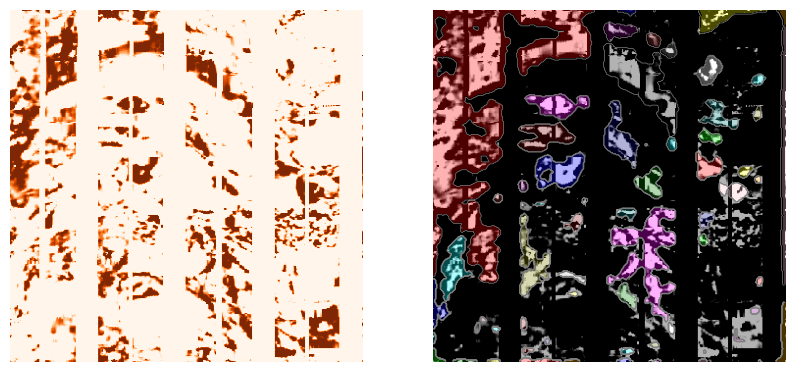

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image[0][0].cpu(), cmap="Oranges")
ax[0].axis("off")
ax[1].imshow(
    label2rgb(
        label=np.array(pred_components),
        image=np.array(image[0][0]),
        colors=colors,
        bg_label=0,
    )
)
ax[1].contour(np.array(pred_components), colors="gray", linewidths=0.5)
ax[1].axis("off")
# Save figure
plt.savefig(os.path.join(f"detr_welld_{image_id}.png"), bbox_inches="tight", dpi=300)

### Compute metrics

Processing image 1/19


GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([1, 360, 360])
IoU: tensor([[0.3185]]) (Mean: 0.3184930682182312)
maps: [tensor(0.3158)]
mean maps: 0.31578946


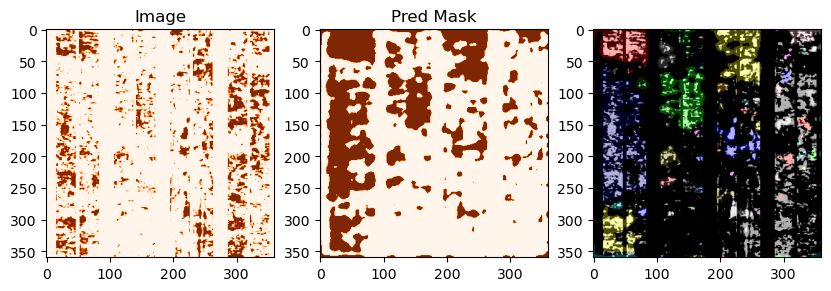

Processing image 2/19
GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([1, 360, 360])
IoU: tensor([[0.3529]]) (Mean: 0.3356744647026062)
maps: [tensor(0.3158), tensor(0.3684)]
mean maps: 0.34210527


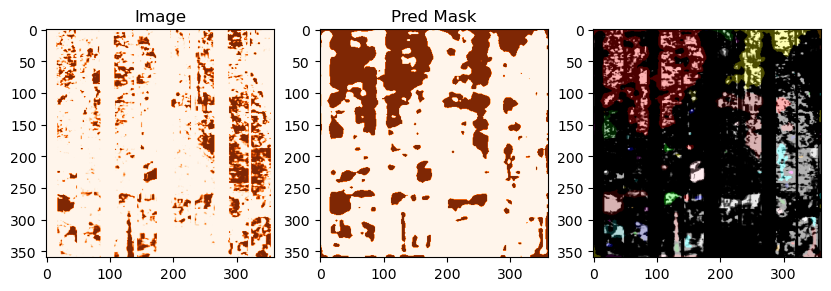

Processing image 3/19
GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([1, 360, 360])
IoU: tensor([[0.4004]]) (Mean: 0.3572395145893097)
maps: [tensor(0.3158), tensor(0.3684), tensor(0.4211)]
mean maps: 0.36842108


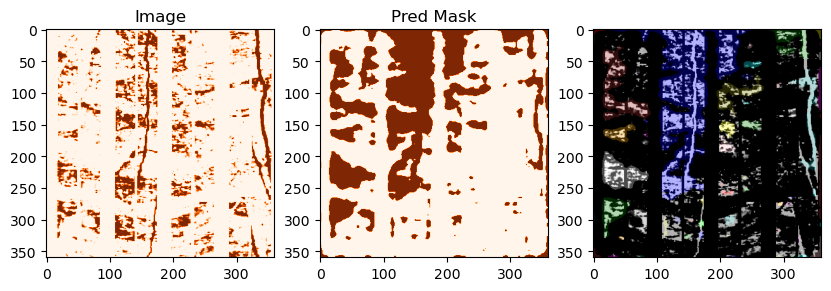

Processing image 4/19
GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([1, 360, 360])
IoU: tensor([[0.3810]]) (Mean: 0.3631897270679474)
maps: [tensor(0.3158), tensor(0.3684), tensor(0.4211), tensor(0.3684)]
mean maps: 0.36842108


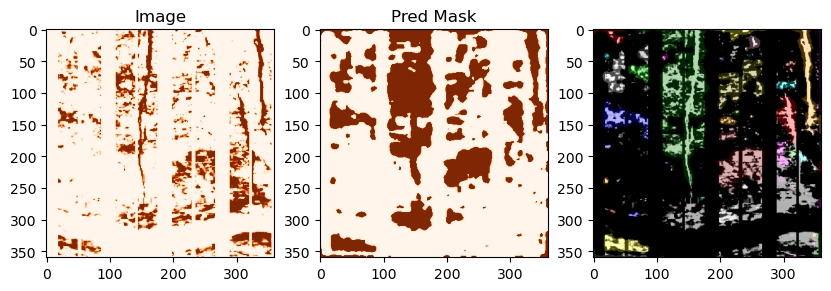

Processing image 5/19
GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([1, 360, 360])
IoU: tensor([[0.3394]]) (Mean: 0.35842907428741455)
maps: [tensor(0.3158), tensor(0.3684), tensor(0.4211), tensor(0.3684), tensor(0.3158)]
mean maps: 0.35789475


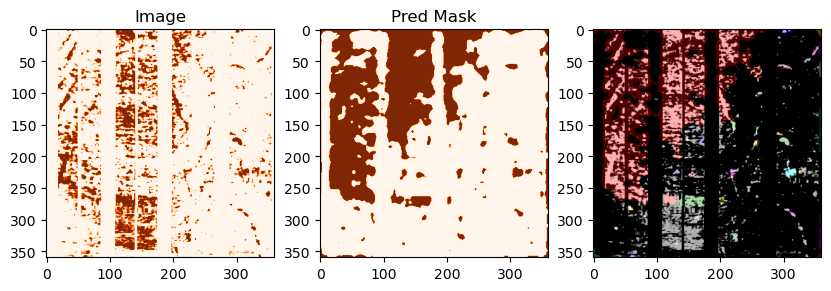

Processing image 6/19
GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([1, 360, 360])
IoU: tensor([[0.5496]]) (Mean: 0.3902841806411743)
maps: [tensor(0.3158), tensor(0.3684), tensor(0.4211), tensor(0.3684), tensor(0.3158), tensor(0.5263)]
mean maps: 0.38596496


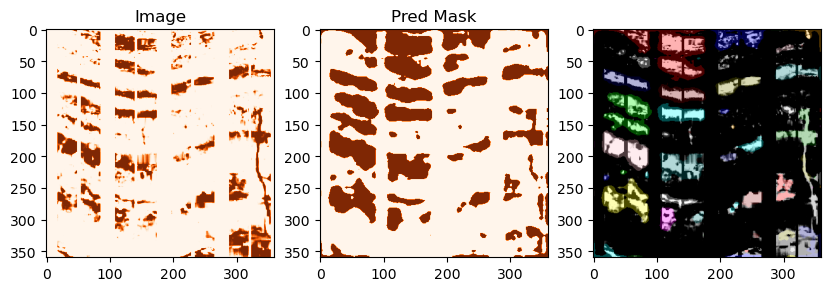

Processing image 7/19
GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([1, 360, 360])
IoU: tensor([[0.6142]]) (Mean: 0.4222654402256012)
maps: [tensor(0.3158), tensor(0.3684), tensor(0.4211), tensor(0.3684), tensor(0.3158), tensor(0.5263), tensor(0.6316)]
mean maps: 0.42105266


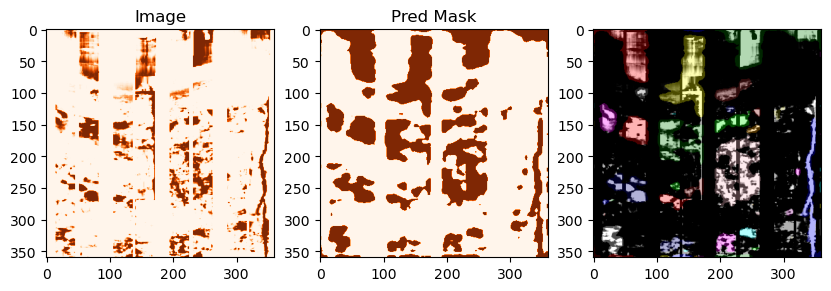

Processing image 8/19
GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([1, 360, 360])
IoU: tensor([[0.3741]]) (Mean: 0.41624143719673157)
maps: [tensor(0.3158), tensor(0.3684), tensor(0.4211), tensor(0.3684), tensor(0.3158), tensor(0.5263), tensor(0.6316), tensor(0.3684)]
mean maps: 0.41447368


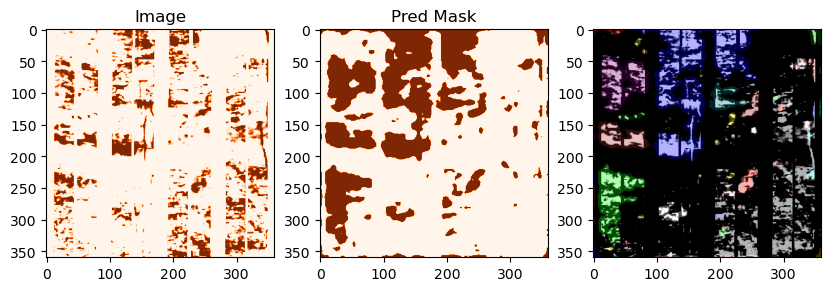

Processing image 9/19
GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([1, 360, 360])
IoU: tensor([[0.3542]]) (Mean: 0.4093485176563263)
maps: [tensor(0.3158), tensor(0.3684), tensor(0.4211), tensor(0.3684), tensor(0.3158), tensor(0.5263), tensor(0.6316), tensor(0.3684), tensor(0.3684)]
mean maps: 0.4093567


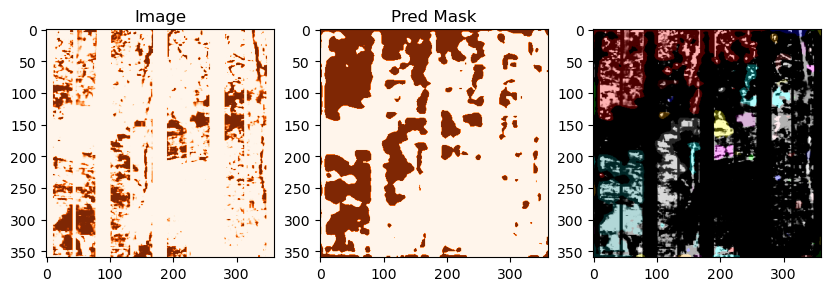

Processing image 10/19
GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([1, 360, 360])
IoU: tensor([[0.4350]]) (Mean: 0.4119139611721039)
maps: [tensor(0.3158), tensor(0.3684), tensor(0.4211), tensor(0.3684), tensor(0.3158), tensor(0.5263), tensor(0.6316), tensor(0.3684), tensor(0.3684), tensor(0.4211)]
mean maps: 0.41052634


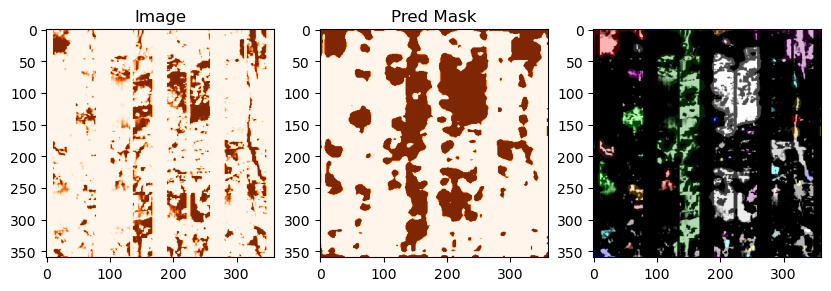

Processing image 11/19
GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([1, 360, 360])
IoU: tensor([[0.3228]]) (Mean: 0.40381553769111633)
maps: [tensor(0.3158), tensor(0.3684), tensor(0.4211), tensor(0.3684), tensor(0.3158), tensor(0.5263), tensor(0.6316), tensor(0.3684), tensor(0.3684), tensor(0.4211), tensor(0.3158)]
mean maps: 0.4019139


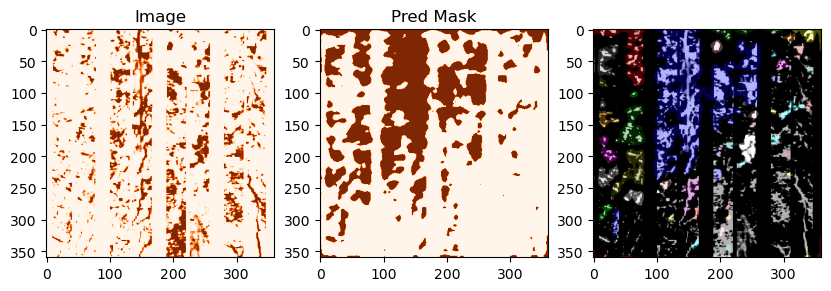

Processing image 12/19
GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([1, 360, 360])
IoU: tensor([[0.3366]]) (Mean: 0.3982110023498535)
maps: [tensor(0.3158), tensor(0.3684), tensor(0.4211), tensor(0.3684), tensor(0.3158), tensor(0.5263), tensor(0.6316), tensor(0.3684), tensor(0.3684), tensor(0.4211), tensor(0.3158), tensor(0.3158)]
mean maps: 0.39473686


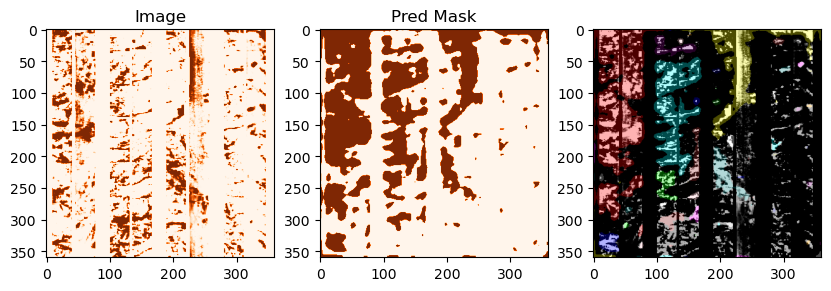

Processing image 13/19
GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([1, 360, 360])
IoU: tensor([[0.3589]]) (Mean: 0.39518868923187256)
maps: [tensor(0.3158), tensor(0.3684), tensor(0.4211), tensor(0.3684), tensor(0.3158), tensor(0.5263), tensor(0.6316), tensor(0.3684), tensor(0.3684), tensor(0.4211), tensor(0.3158), tensor(0.3158), tensor(0.3684)]
mean maps: 0.39271256


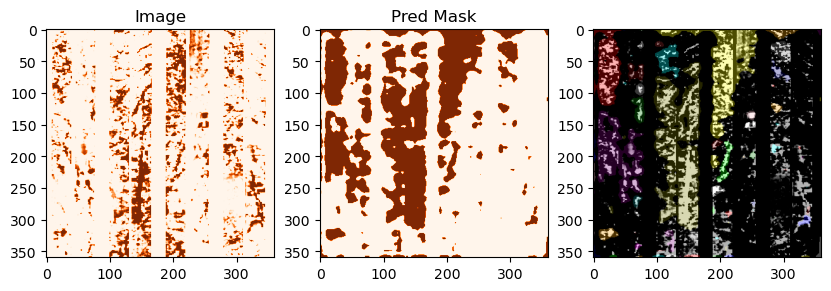

Processing image 14/19
GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([1, 360, 360])
IoU: tensor([[0.3948]]) (Mean: 0.39516371488571167)
maps: [tensor(0.3158), tensor(0.3684), tensor(0.4211), tensor(0.3684), tensor(0.3158), tensor(0.5263), tensor(0.6316), tensor(0.3684), tensor(0.3684), tensor(0.4211), tensor(0.3158), tensor(0.3158), tensor(0.3684), tensor(0.3684)]
mean maps: 0.39097744


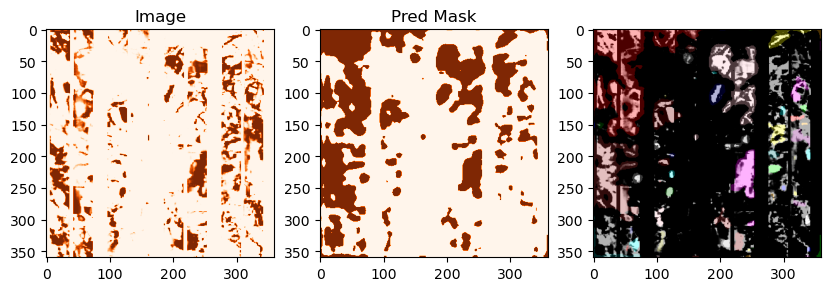

Processing image 15/19
GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([1, 360, 360])
IoU: tensor([[0.3400]]) (Mean: 0.3914845585823059)
maps: [tensor(0.3158), tensor(0.3684), tensor(0.4211), tensor(0.3684), tensor(0.3158), tensor(0.5263), tensor(0.6316), tensor(0.3684), tensor(0.3684), tensor(0.4211), tensor(0.3158), tensor(0.3158), tensor(0.3684), tensor(0.3684), tensor(0.3158)]
mean maps: 0.3859649


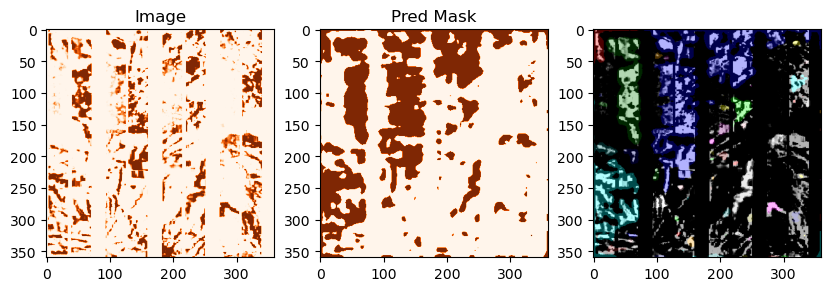

Processing image 16/19
GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([1, 360, 360])
IoU: tensor([[0.3602]]) (Mean: 0.38952720165252686)
maps: [tensor(0.3158), tensor(0.3684), tensor(0.4211), tensor(0.3684), tensor(0.3158), tensor(0.5263), tensor(0.6316), tensor(0.3684), tensor(0.3684), tensor(0.4211), tensor(0.3158), tensor(0.3158), tensor(0.3684), tensor(0.3684), tensor(0.3158), tensor(0.3684)]
mean maps: 0.3848684


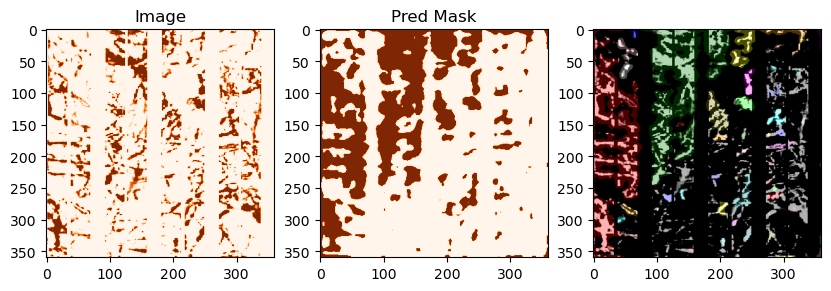

Processing image 17/19
GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([1, 360, 360])
IoU: tensor([[0.3671]]) (Mean: 0.3882100284099579)
maps: [tensor(0.3158), tensor(0.3684), tensor(0.4211), tensor(0.3684), tensor(0.3158), tensor(0.5263), tensor(0.6316), tensor(0.3684), tensor(0.3684), tensor(0.4211), tensor(0.3158), tensor(0.3158), tensor(0.3684), tensor(0.3684), tensor(0.3158), tensor(0.3684), tensor(0.3684)]
mean maps: 0.3839009


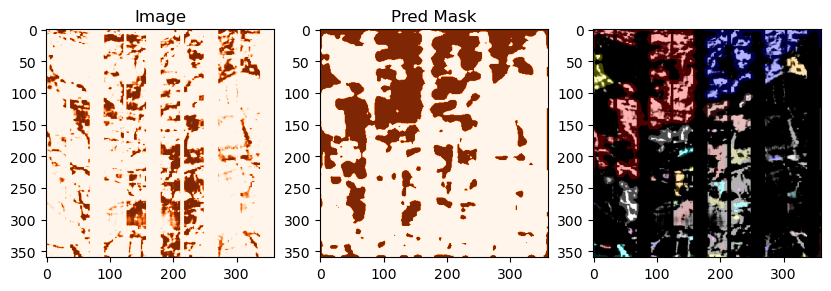

Processing image 18/19
GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([1, 360, 360])
IoU: tensor([[0.3698]]) (Mean: 0.3871872127056122)
maps: [tensor(0.3158), tensor(0.3684), tensor(0.4211), tensor(0.3684), tensor(0.3158), tensor(0.5263), tensor(0.6316), tensor(0.3684), tensor(0.3684), tensor(0.4211), tensor(0.3158), tensor(0.3158), tensor(0.3684), tensor(0.3684), tensor(0.3158), tensor(0.3684), tensor(0.3684), tensor(0.3684)]
mean maps: 0.38304093


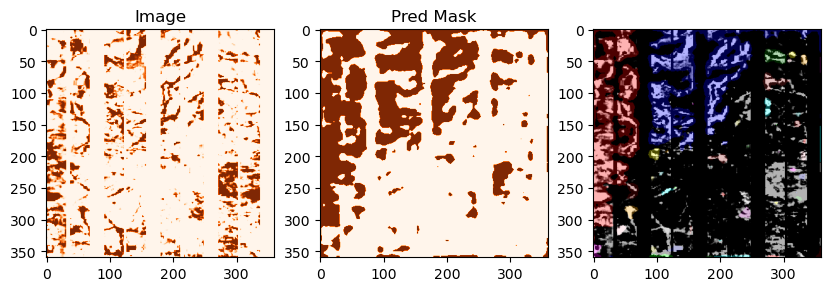

Processing image 19/19
GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([1, 360, 360])
IoU: tensor([[0.3651]]) (Mean: 0.38602274656295776)
maps: [tensor(0.3158), tensor(0.3684), tensor(0.4211), tensor(0.3684), tensor(0.3158), tensor(0.5263), tensor(0.6316), tensor(0.3684), tensor(0.3684), tensor(0.4211), tensor(0.3158), tensor(0.3158), tensor(0.3684), tensor(0.3684), tensor(0.3158), tensor(0.3684), tensor(0.3684), tensor(0.3684), tensor(0.3684)]
mean maps: 0.38227147


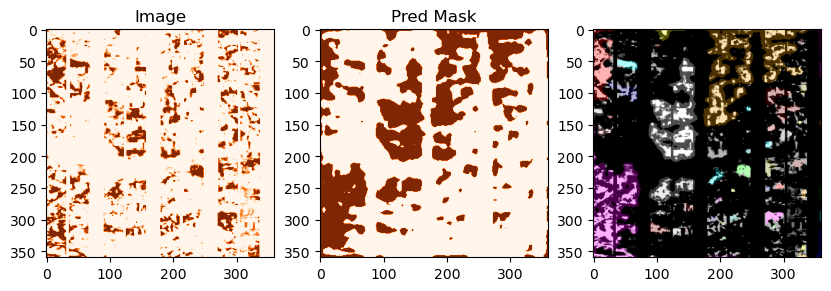

In [39]:
map_metric = MeanAveragePrecision(
    iou_type="segm", iou_thresholds=np.arange(start=0.05, stop=1.00, step=0.05).tolist(), extended_summary=True
)
ious = []
maps = []
model.eval()
for idx in range(len(dataset)):
    print(f"Processing image {idx + 1}/{len(dataset)}")
    image, target = dataset[idx]
    image = image.unsqueeze(0)
    # convert target to uint8
    target["masks"] = target["masks"].byte()
    masks = target["masks"]
    gt_mask = torch.zeros_like(masks[0])
    for mask in masks:
        gt_mask = torch.logical_or(gt_mask, mask)
    gt_mask = gt_mask.byte().unsqueeze(0)
    print(f"GT Mask shape: {gt_mask.shape}")
    # evaluate sample on model
    with torch.no_grad():
        image = image.to(model.device)
        outputs = model(image)
        orig_target_sizes = torch.stack([t["orig_size"] for t in labels], dim=0).to(
            model.device
        )
        preds = model.postprocessors["bbox"](outputs, orig_target_sizes)
        if "segm" in model.postprocessors.keys():
            target_sizes = torch.stack([t["size"] for t in labels], dim=0).to(
                model.device
            )
            preds = model.postprocessors["segm"](
                preds, outputs, orig_target_sizes, target_sizes
            )
    # Move preds to cpu
    for pred in preds:
        for key in pred.keys():
            pred[key] = pred[key].cpu()
    # join mask predictions
    pred_mask = torch.zeros_like(preds[0]["masks"][0])
    for pred in preds:
        pred["masks"] = torch.squeeze(pred["masks"] > LitDETR.MASK_THRESHOLD, dim=1).byte()
        for score, mask in zip(pred["scores"], pred["masks"]):
            # if score > LitDETR.MASK_THRESHOLD:
            pred_mask = torch.logical_or(pred_mask, mask)
    pred_mask = pred_mask.cpu()
    # pred_mask = torch.where(pred_mask > 1, 1, pred_mask)
    # pred_mask = (pred_mask > LitMaskRCNN.MASK_THRESHOLD).byte().cpu()
    print(f"Pred Mask shape: {pred_mask.shape}")
    # Calculate IoU
    iou = calc_iou(pred_mask, gt_mask)
    # Calculate mAP
    map_preds = [
        {
            "masks": pred_mask,
            "scores": torch.tensor([1.0]),
            "labels": torch.tensor([1]),
        }
    ]
    map_target = [
        {
            "masks": gt_mask,
            "labels": torch.tensor([1]),
        }
    ]
    maps.append(map_metric(preds=map_preds, target=map_target))
    # maps.append(map_metric(preds=preds, target=[target]))
    ious.append(iou)
    mean_iou = np.mean(ious)
    print(f"IoU: {iou} (Mean: {mean_iou})")
    print("maps:", [map["map"] for map in maps])
    print("mean maps:", np.mean([map["map"] for map in maps]))
    # Plot images
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    image = image.cpu()
    pred_components = skimage.measure.label(
        pred_mask[0].numpy(), background=0
    )
    axs[0].imshow(image[0][0], cmap="Oranges")
    axs[0].set_title("Image")
    axs[1].imshow(pred_mask[0], cmap="Oranges")
    axs[1].set_title("Pred Mask")
    axs[2].imshow(
        label2rgb(
            label=np.array(pred_components),
            image=np.array(image[0][0]),
            colors=colors,
            bg_label=0,
        )
    )
    plt.show()

In [30]:
print(f"Mean IoU: {np.mean(ious)}")
map_metric.compute()

Mean IoU: 0.12197074294090271


{'map': tensor(0.0836),
 'map_50': tensor(0.),
 'map_75': tensor(-1.),
 'map_small': tensor(-1.),
 'map_medium': tensor(-1.),
 'map_large': tensor(0.0836),
 'mar_1': tensor(0.1025),
 'mar_10': tensor(0.1025),
 'mar_100': tensor(0.1025),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(0.1025),
 'ious': {(0, 1): tensor(0.0964),
  (1, 1): tensor(0.0808),
  (2, 1): tensor(0.1168),
  (3, 1): tensor(0.0841),
  (4, 1): tensor(0.1359),
  (5, 1): tensor(0.1069),
  (6, 1): tensor(0.1515),
  (7, 1): tensor(0.1200),
  (8, 1): tensor(0.0999),
  (9, 1): tensor(0.0952),
  (10, 1): tensor(0.1067),
  (11, 1): tensor(0.1290),
  (12, 1): tensor(0.1119),
  (13, 1): tensor(0.1139),
  (14, 1): tensor(0.1234),
  (15, 1): tensor(0.1557),
  (16, 1): tensor(0.1788),
  (17, 1): tensor(0.1685),
  (18, 1): tensor(0.1422)},
 'precision': tensor([[[[[ 1.0000,  1.0000,  1.0000],
            [-1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000],
            [ 1.0000,  1.0000,